In [1]:
import scanpy as sc
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import re
import collections

In [5]:
sc.set_figure_params(dpi_save=300, dpi=100, format="pdf", frameon=False, fontsize=10, transparent=True)
sc.settings.verbosity = 3
sc.settings.figdir = "/storage/data/plots/"

In [3]:
adata = sc.read("/storage/data/organoid_atlas_adatas/230620_10_updated_manual_annotation.h5ad")

# Compositional Plots

/tmp/ipykernel_33195/3141021553.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["assay_differentiation_clean"] = df_full["assay_differentiation"].astype(str)
/tmp/ipykernel_33195/3141021553.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full["assay_differentiation_clean"] = pd.Categorical([re.sub("\s?\(.*?\)\s?", "", i) for i in df_full["assay_differentiation_clean"]])
/tmp/ipykernel_33195/3141021553.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

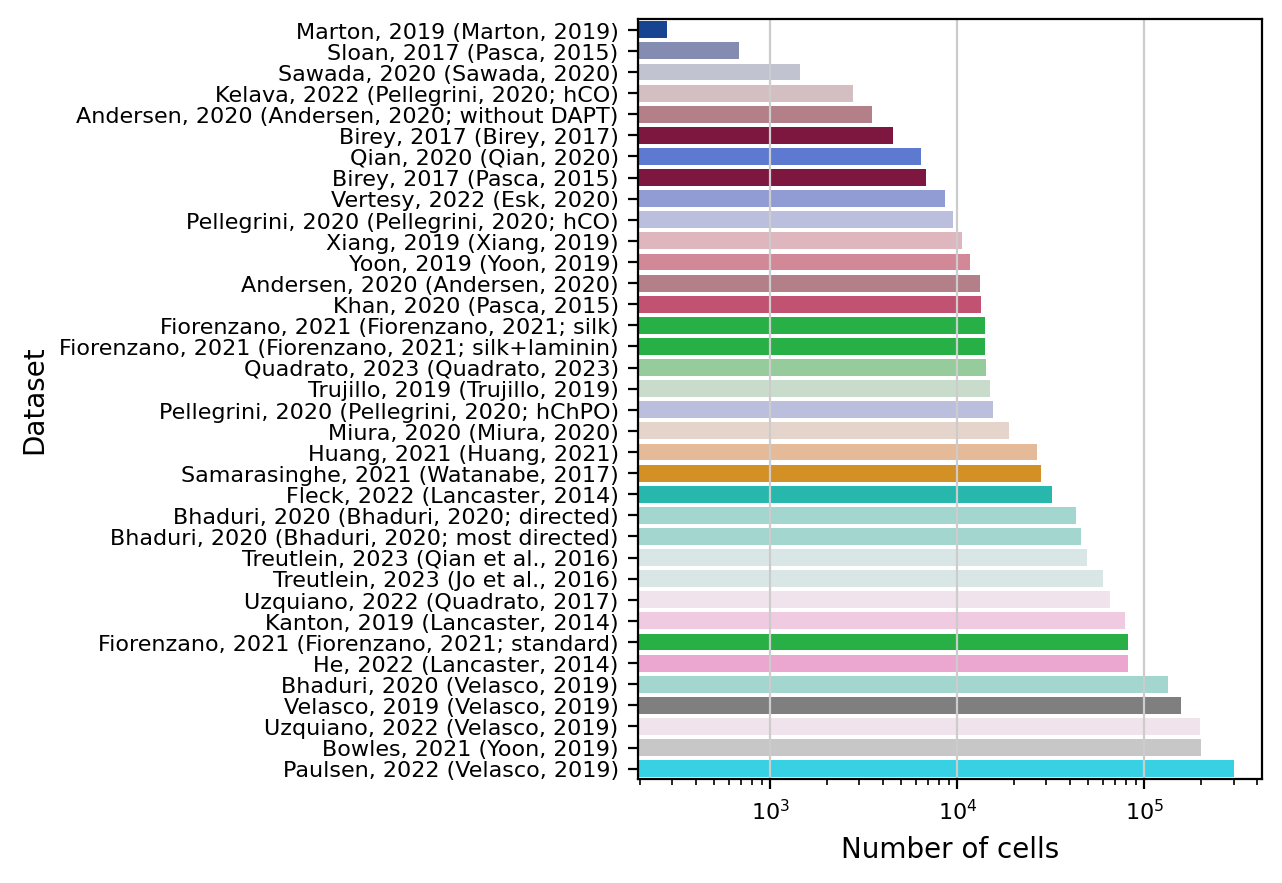

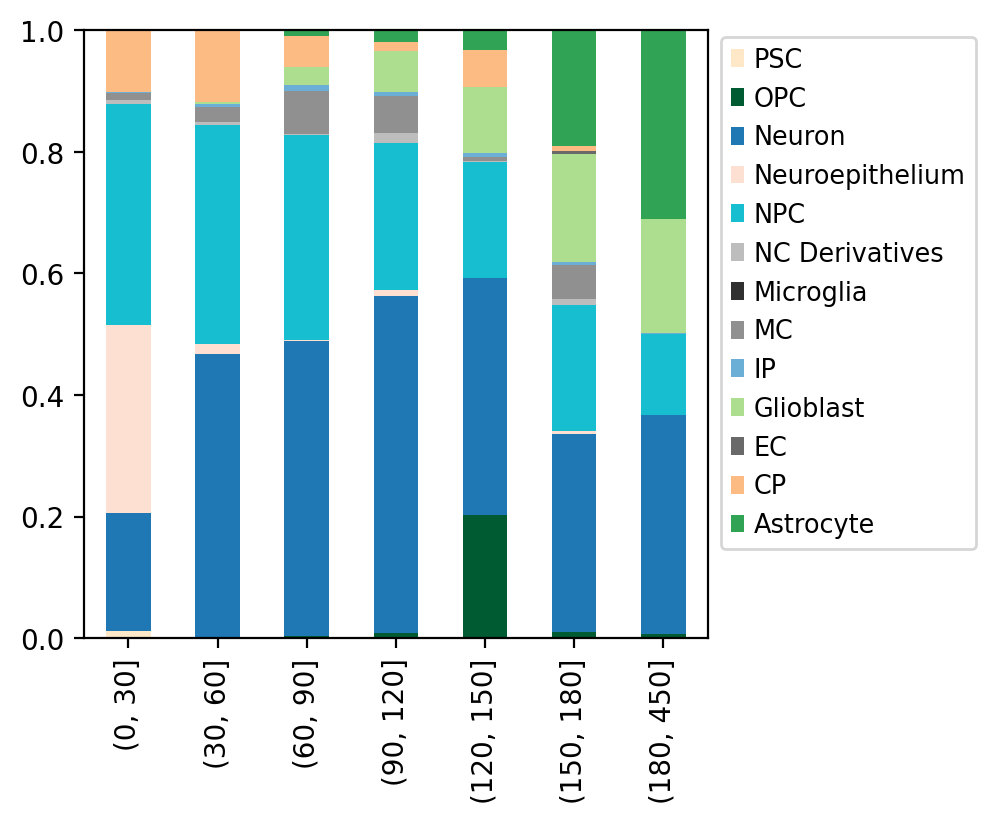

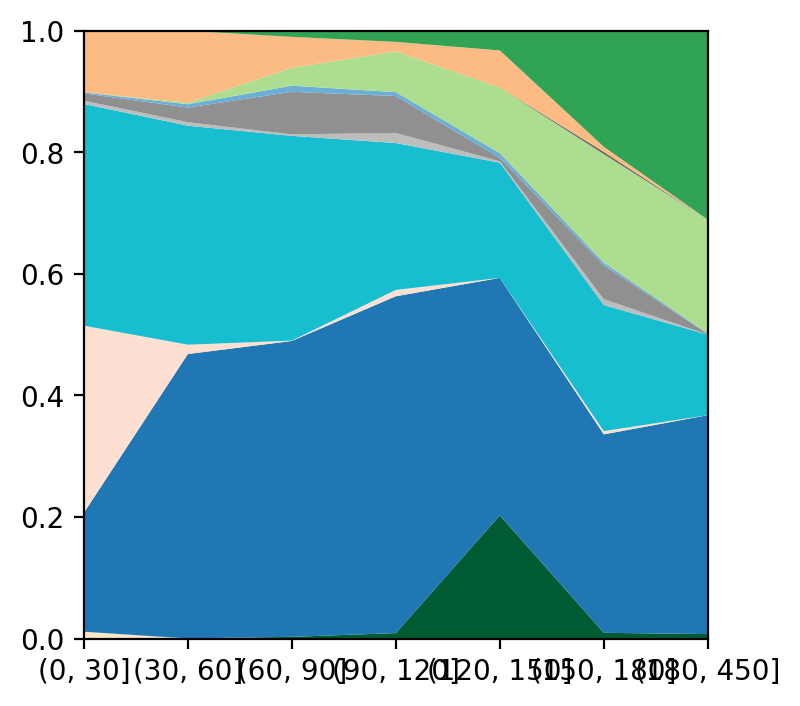

In [10]:
colormap_l1 = {
    'PSC': '#fee8c8',
    'Neuroepithelium': '#fee0d2',
    'NPC': '#17becf',
    'IP': '#6baed6',
    'Neuron': '#1f77b4',
    'Glioblast': '#addd8e',
    'Astrocyte': '#31a354',
    'OPC': '#005a32',
    'CP': '#fdbb84',
    'Microglia': '#303030',
    'NC Derivatives': '#bdbdbd',
    'EC': '#696969',
    'MC': '#909090',
}
colormap_l2 = {
    'PSC': '#fee8c8',
    'Neuroepithelium': '#fee0d2',
    'Dorsal Telencephalic NPC': '#9ecae1',
    'Ventral Telencephalic NPC': '#bcbddc',
    'Non-telencephalic NPC': '#fcbba1',
    'Dorsal Telencephalic IP': '#6baed6',
    'Dorsal Telencephalic Neuron': '#4292c6',
    'Ventral Telencephalic Neuron': '#9e9ac8',
    'Non-telencephalic Neuron': '#fb6a4a',
    'Glioblast': '#addd8e',
    'Astrocyte': '#31a354',
    'OPC': '#005a32',
    'CP': '#fdbb84',
    'Microglia': '#303030',
    'NC Derivatives': '#bdbdbd',
    'EC': '#696969',
    'MC': '#909090',
}

df_full = adata.obs[["publication", "assay_differentiation", "organoid_age_days", "annot_level_1", "assay_sc"]]
df_full["assay_differentiation_clean"] = df_full["assay_differentiation"].astype(str)
df_full["assay_differentiation_clean"] = pd.Categorical([re.sub("\s?\(.*?\)\s?", "", i) for i in df_full["assay_differentiation_clean"]])
df_full["publication_protocol"] = pd.Categorical(df_full["publication"].astype(str) + " (" + df_full["assay_differentiation_clean"].astype(str) + ")")
df_full["age_bins"] = pd.cut(df_full['organoid_age_days'], [0,30,60,90,120,150,180,450])

df_bars = df_full['publication_protocol'].value_counts().to_frame().sort_values("publication_protocol").reset_index()
df_bars["index"] = df_bars["index"].cat.reorder_categories(df_bars["index"].tolist())
df_bars["publication"] = df_bars["index"].str.split(" \(").str[0]
with plt.rc_context({"figure.figsize": (4,5)}):
    g = sns.barplot(df_bars, y="index", x="publication_protocol", palette=[sc.pl.palettes.default_28[np.where(df_bars["publication"].unique()==i)[0][0]] for i in df_bars["publication"]])
    g.set_xscale("log")
    plt.xlabel('Number of cells', fontsize=10);
    plt.ylabel('Dataset', fontsize=10);
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.savefig("/storage/data/plots/barchart_ncells.pdf", bbox_inches="tight", dpi=300)
    plt.show()

dfg = df_full.groupby(["age_bins", "publication_protocol", "annot_level_1"]).count()["assay_sc"]
df = pd.DataFrame(index = df_full["annot_level_1"].cat.categories)
for t in dfg.index.get_level_values("age_bins").unique():
    df2 = pd.DataFrame(index = df_full["annot_level_1"].cat.categories)
    for p in dfg.index.get_level_values("publication_protocol").unique():
        if dfg.loc[(t, p)].sum() > 0:
            df2[p] = dfg.loc[(t, p)] / dfg.loc[(t, p)].sum()
    df[str(t)] = df2.mean(axis=1)
    
df[::-1].T.plot(kind="bar", stacked=True, color=[colormap_l1[i] for i in df[::-1].index])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.grid(False)
plt.ylim((0,1))
plt.savefig("/storage/data/plots/ct_fraction_timepoints_bars_l1.pdf", bbox_inches="tight", dpi=300)
plt.show()

plt.stackplot(*[df.T.reset_index()[c] for c in ['index']+df.T.columns.tolist()[::-1]], colors=[colormap_l1[i] for i in df.T.columns.tolist()[::-1]])
plt.grid(False)
plt.xlim((0,6))
plt.ylim((0,1))
plt.savefig("/storage/data/plots/ct_fraction_timepoints_area_l1.pdf", bbox_inches="tight", dpi=300)
plt.show()

# Dotplots Markers

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


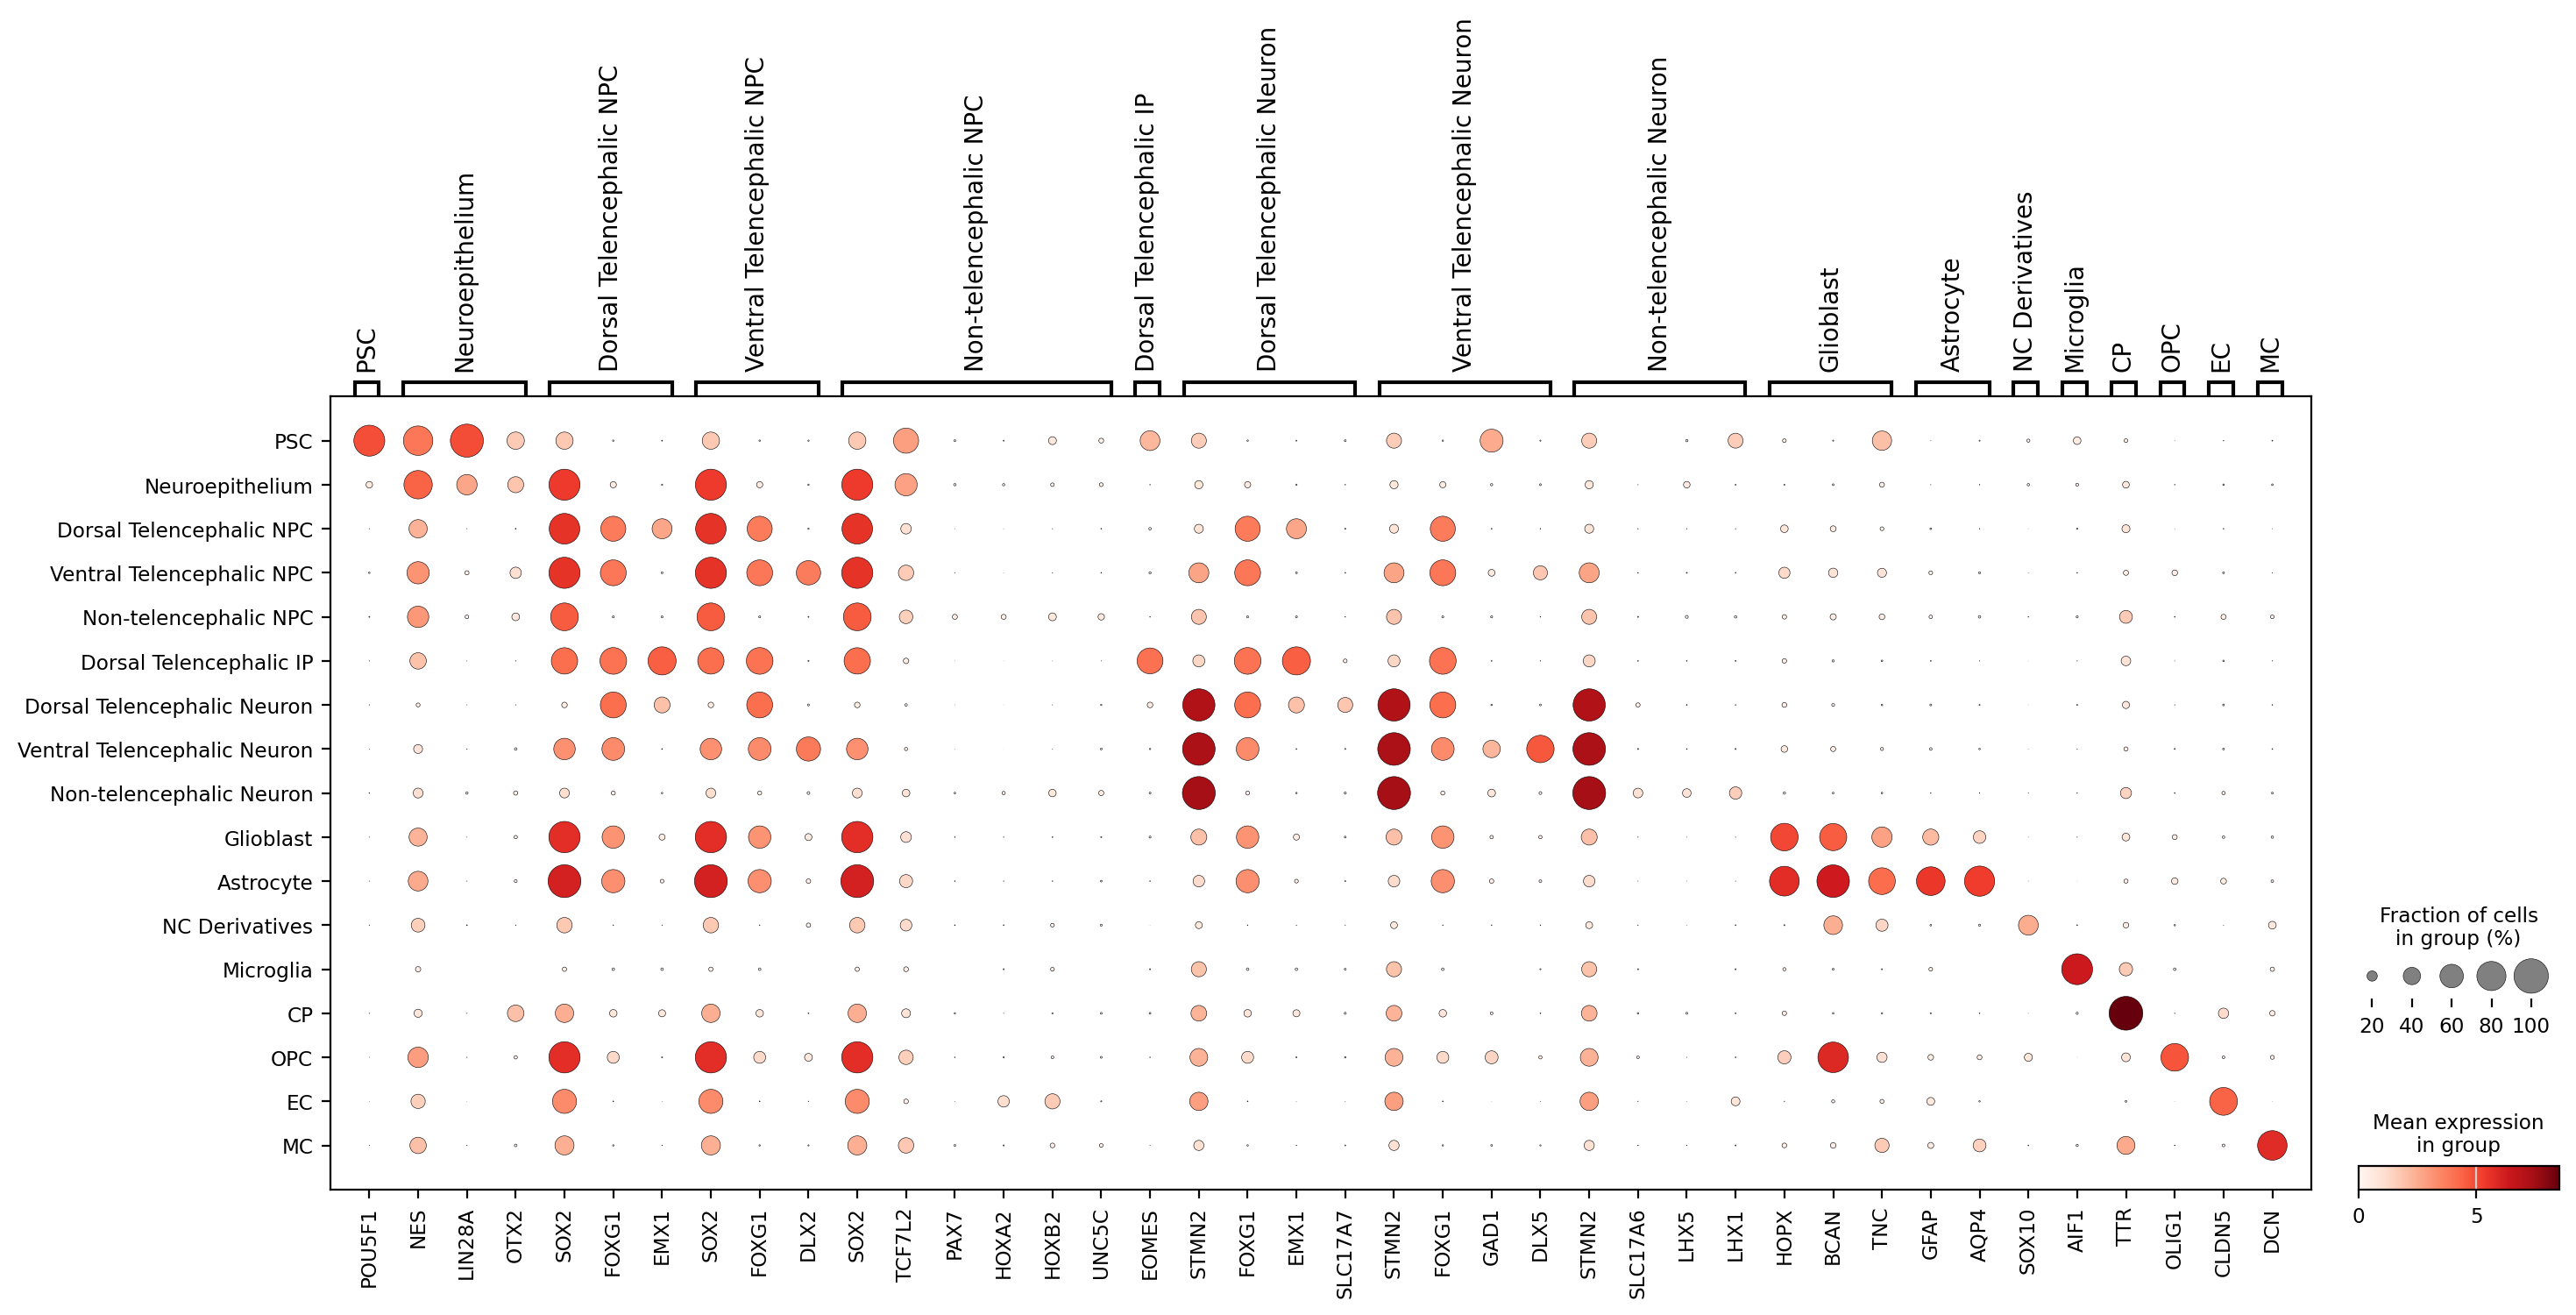

In [238]:
with open("/storage/data/organoid_atlas_adatas/230510_data/brain_markers_v3.4.yaml", "r") as stream:
    try:
        hierarchy = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

markers = collections.OrderedDict({
    "PSC": ["POU5F1"],
    "Neuroepithelium": ["NES", "LIN28A", "OTX2"],
    "Dorsal Telencephalic NPC": ["SOX2", "FOXG1", "EMX1"],
    "Ventral Telencephalic NPC": ["SOX2", "FOXG1", "DLX2"],
    "Non-telencephalic NPC": ["SOX2", "TCF7L2", "PAX7", "HOXA2", "HOXB2", "UNC5C"],
    "Dorsal Telencephalic IP": ["EOMES"],
    "Dorsal Telencephalic Neuron": ["STMN2", "FOXG1", "EMX1", "SLC17A7"],
    "Ventral Telencephalic Neuron": ["STMN2", "FOXG1", "GAD1", "DLX5"],
    "Non-telencephalic Neuron": ["STMN2", "SLC17A6", "LHX5", "LHX1"],
    "Glioblast": ["HOPX", "BCAN", "TNC"],
    "Astrocyte": ["GFAP", "AQP4"],
    "NC Derivatives": ["SOX10"],
    "Microglia": ["AIF1"],
    "CP": ["TTR"],
    "OPC": ["OLIG1"],
    "EC": ["CLDN5"],
    "MC": ["DCN"],
})

markerlist = []
positionlist = [(-1,)]
for k, v in markers.items():
    markerlist.extend(v)
    positionlist.append((positionlist[-1][-1]+1, positionlist[-1][-1]+len(v)))

adata.obs["annot_level_2"] = adata.obs["annot_level_2"].cat.reorder_categories(list(markers.keys()))
sc.pl.dotplot(adata, groupby="annot_level_2", var_names=markerlist, var_group_positions=positionlist[1:], var_group_labels=list(markers.keys()), save="level2_markers.pdf")

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


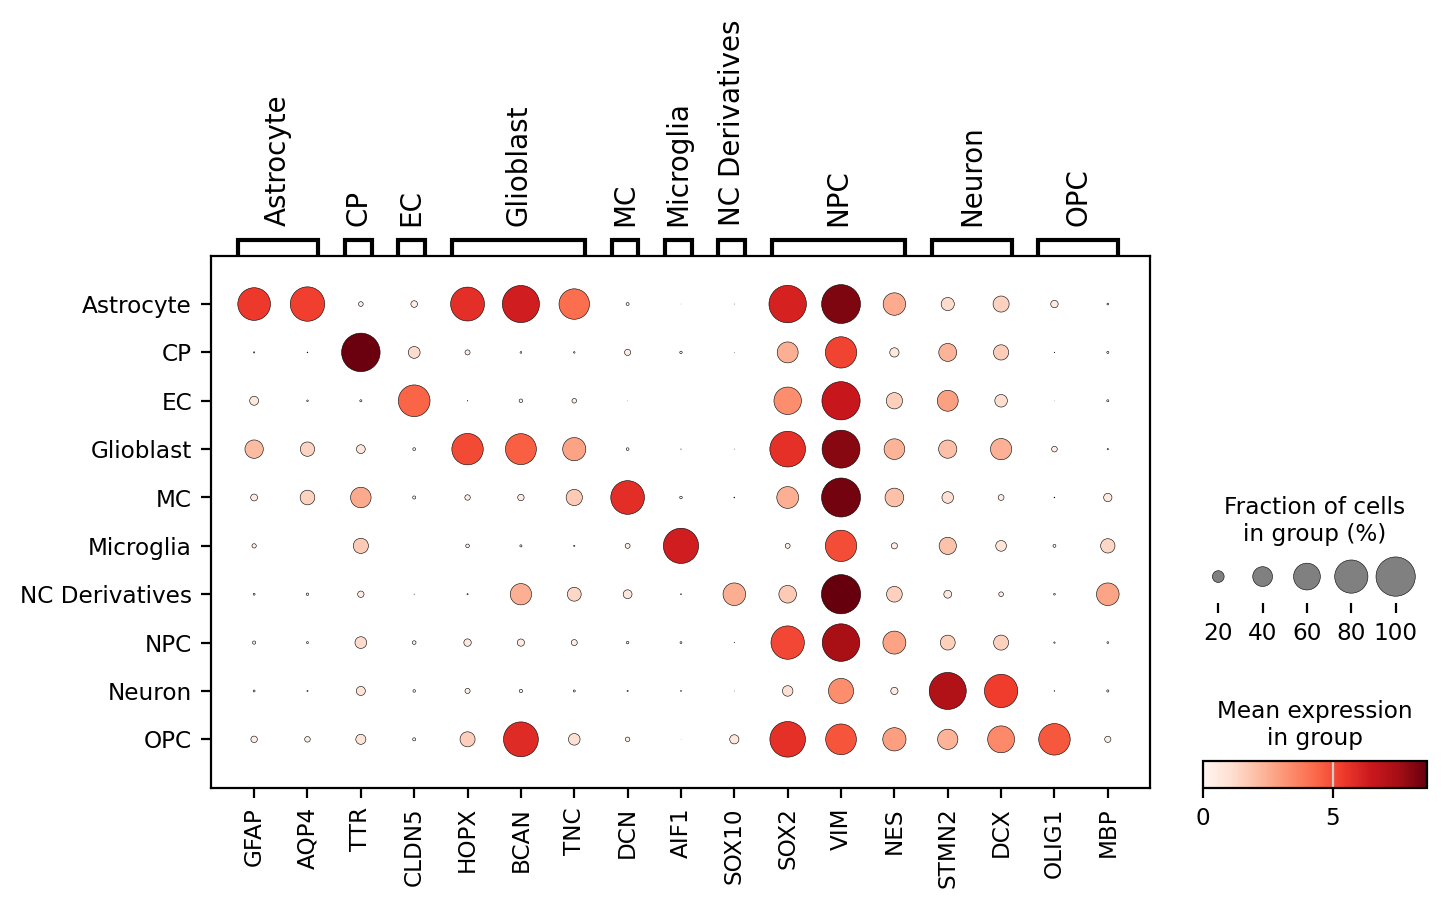

In [58]:
with open("/storage/data/organoid_atlas_adatas/230510_data/brain_markers_v3.4.yaml", "r") as stream:
    try:
        hierarchy = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

ct_conv_l1 = {
 'Astrocyte': "astrocyte",
 'CP': "choroid_plexus_epithelium",
 'EC': 'vascular_endothelial_cell',
 'Glioblast': ["neural_progenitor_cell", "glioblast"],
 'MC': "mesenchymal_cell",
 'Microglia': "microglia",
 'NC Derivatives': "neural_crest",
 'NPC': "neural_progenitor_cell",
 'Neuron': "neuron",
 'OPC': "oligodendrocyte_lineage",
}

markers = {}
markerlist = []
positionlist = [(-1,)]
for k, v in ct_conv_l1.items():
    if isinstance(v, list):
        vv = hierarchy[v[0]]["subtypes"][v[1]]["marker_genes"]
    else:
        vv = hierarchy[v]["marker_genes"]
    markers[k] = vv
    markerlist.extend(vv)
    positionlist.append((positionlist[-1][-1]+1, positionlist[-1][-1]+len(vv)))

sc.pl.dotplot(adata[adata.obs['annot_level_1'].isin(ct_conv_l1.keys())], groupby="annot_level_1", var_names=markerlist, var_group_positions=positionlist[1:], var_group_labels=list(markers.keys()) , save="level1_markers.pdf")

# Subset UMAPS

In [87]:
sc.set_figure_params(dpi_save=300, dpi=100, format="png", frameon=False, fontsize=10, transparent=True)
sc.settings.figdir = "/storage/data/plots/protocol_umaps/"

In [91]:
adata.obs["assay_differentiation_clean"] = adata.obs["assay_differentiation"].astype(str)
adata.obs["assay_differentiation_clean"] = pd.Categorical([re.sub("\s?\(.*?\)\s?", "", i) for i in adata.obs["assay_differentiation_clean"]])

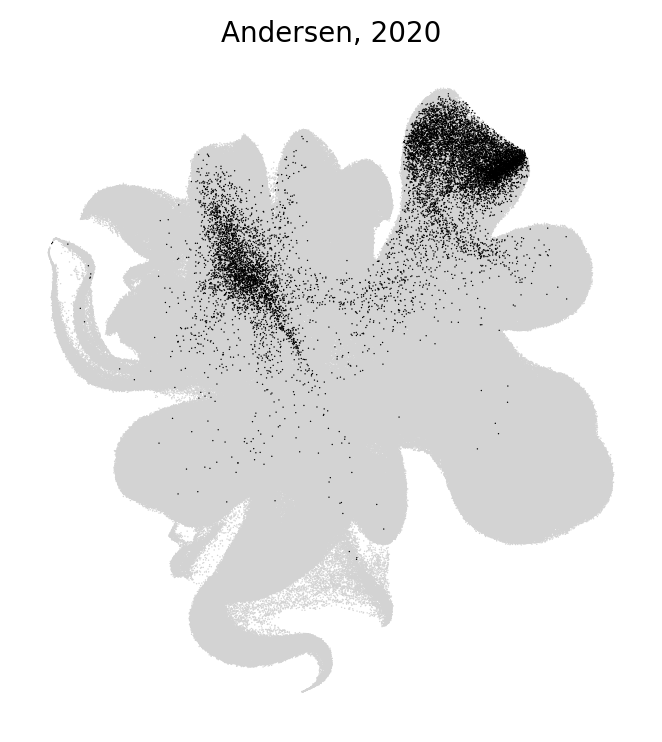

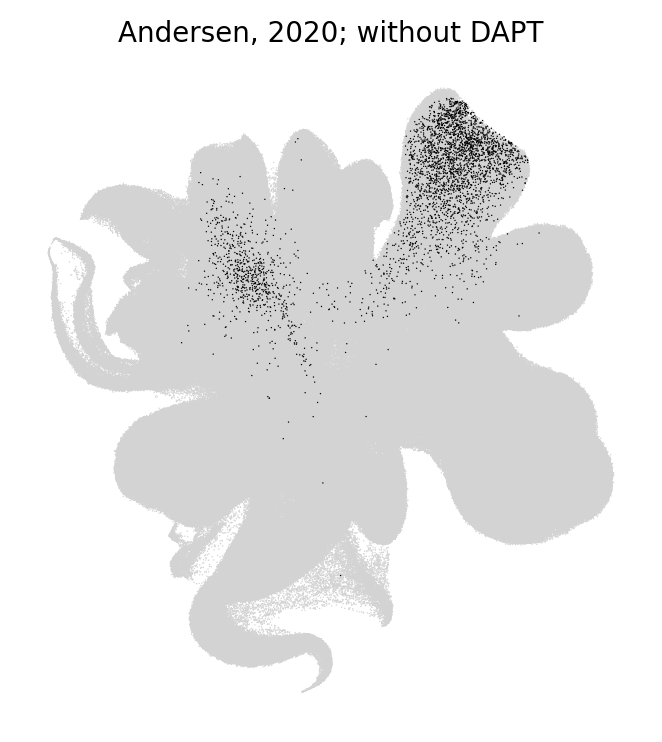

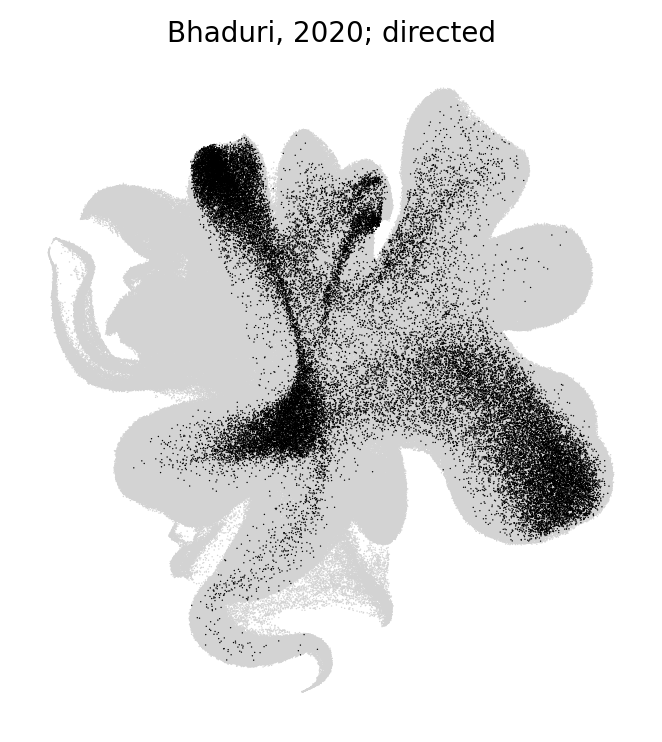

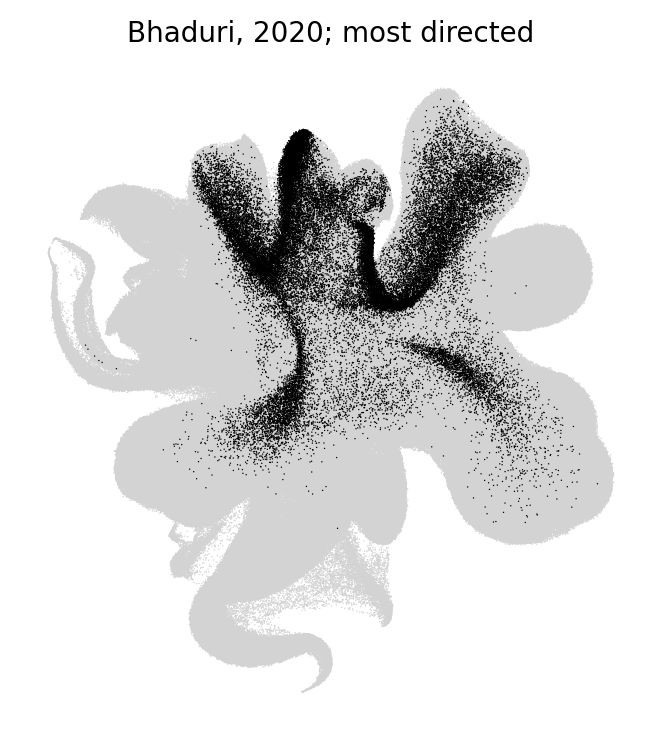

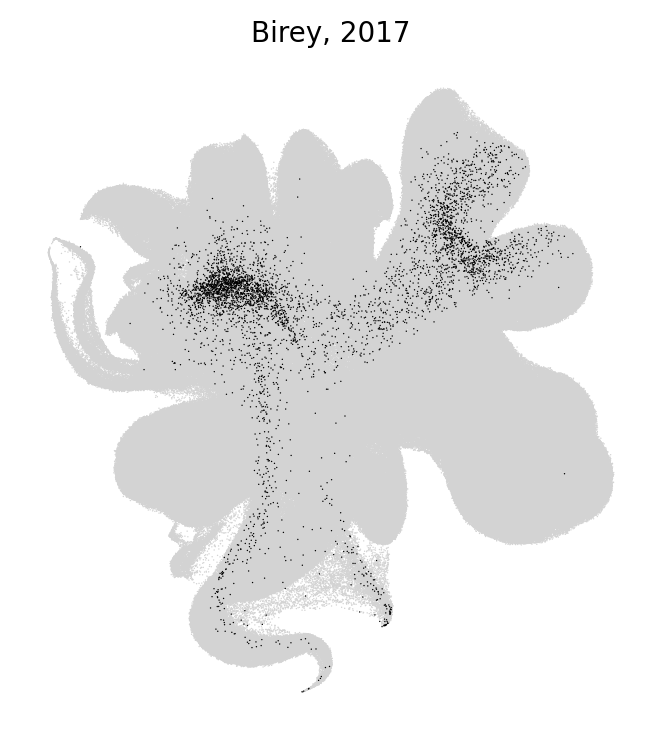

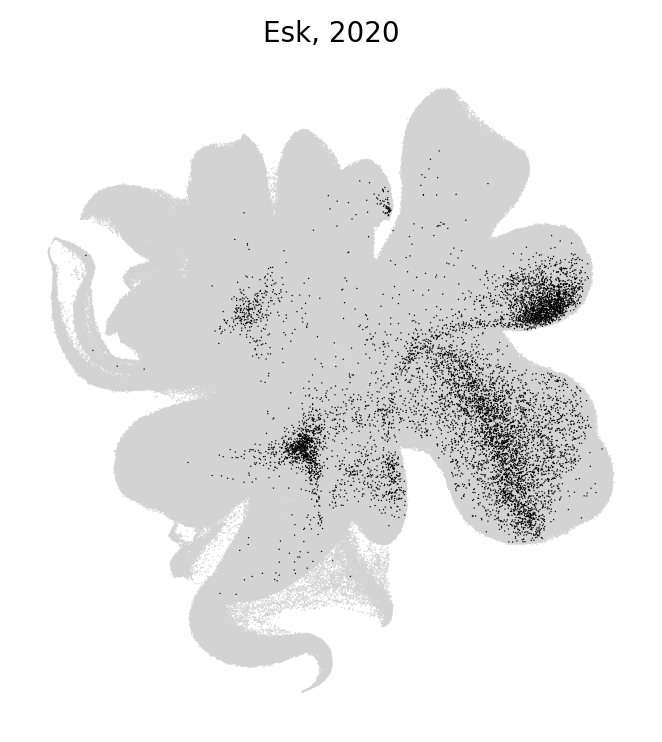

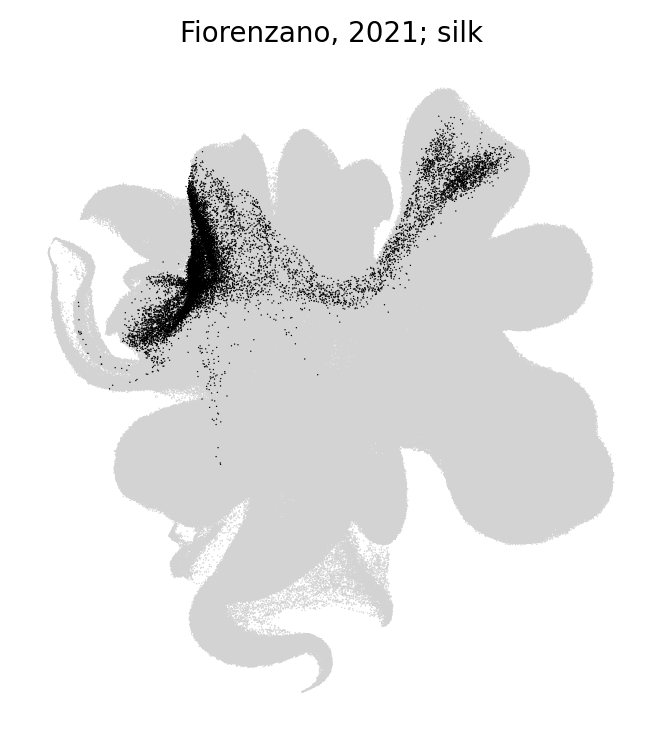

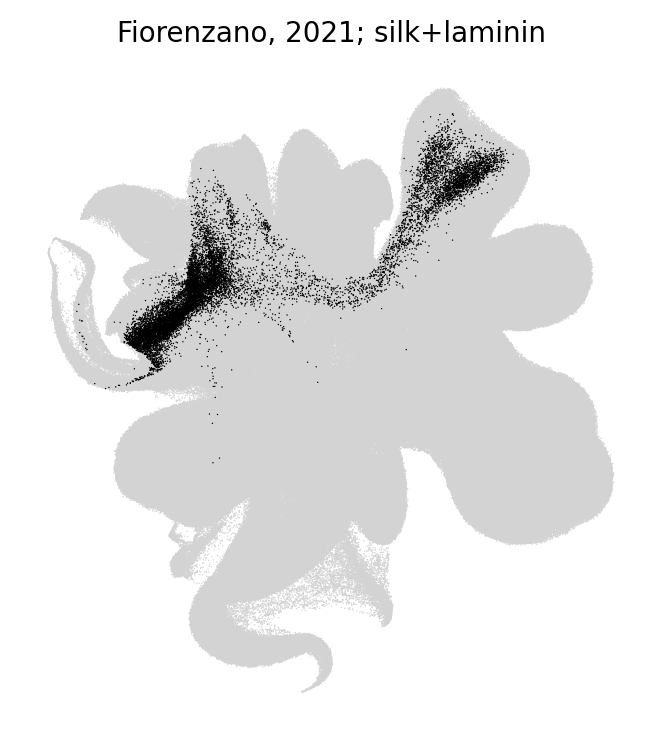

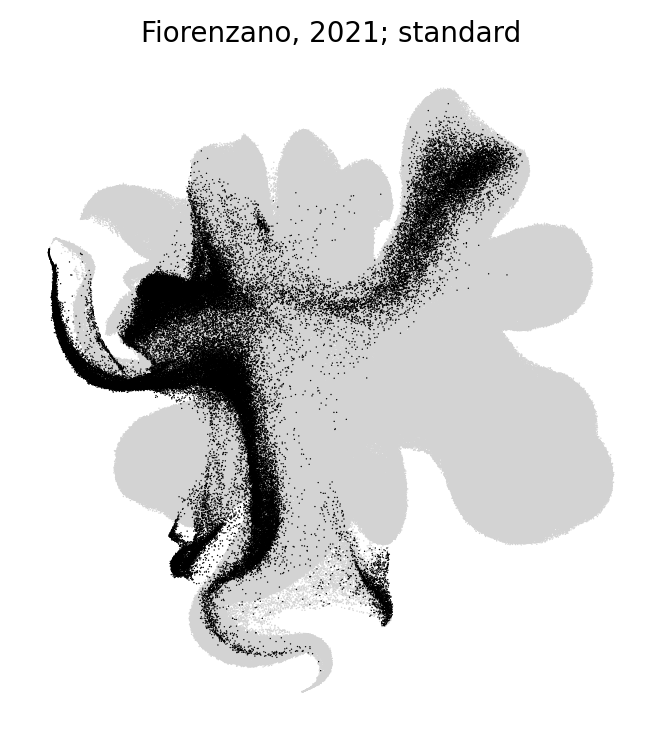

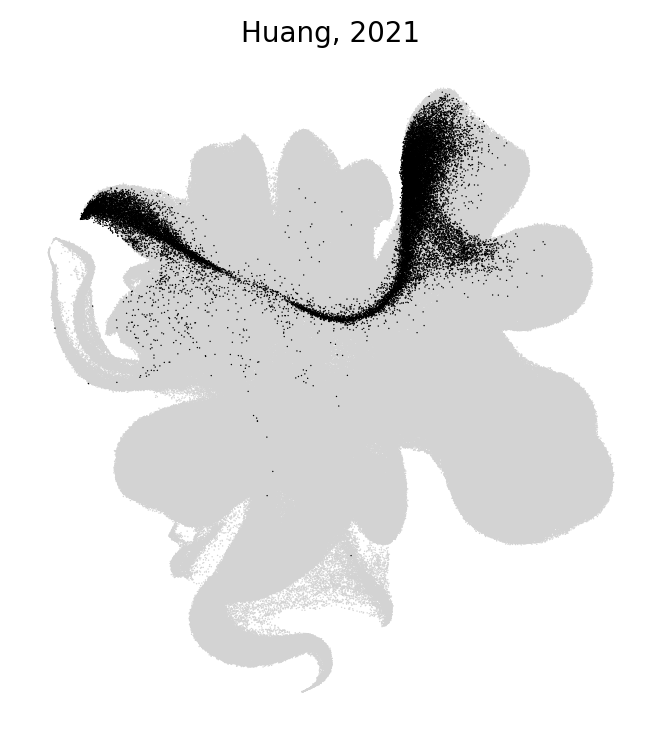

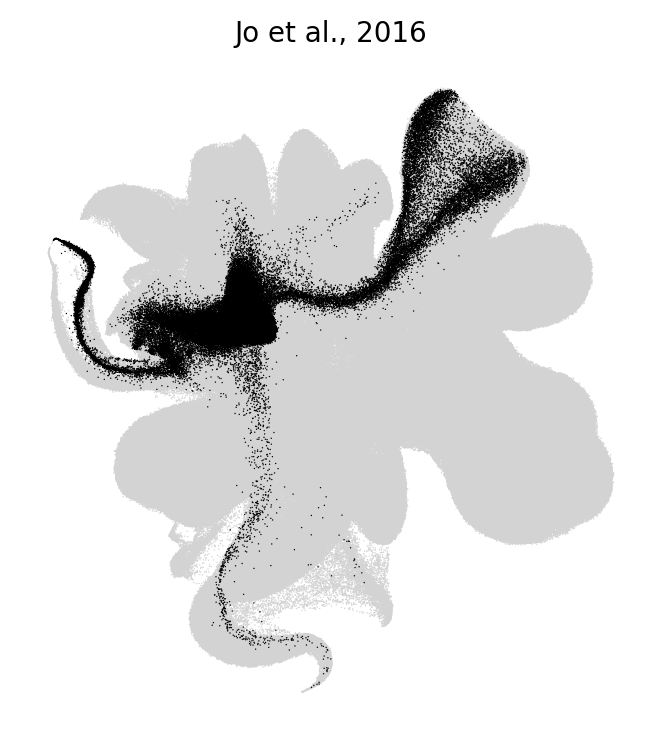

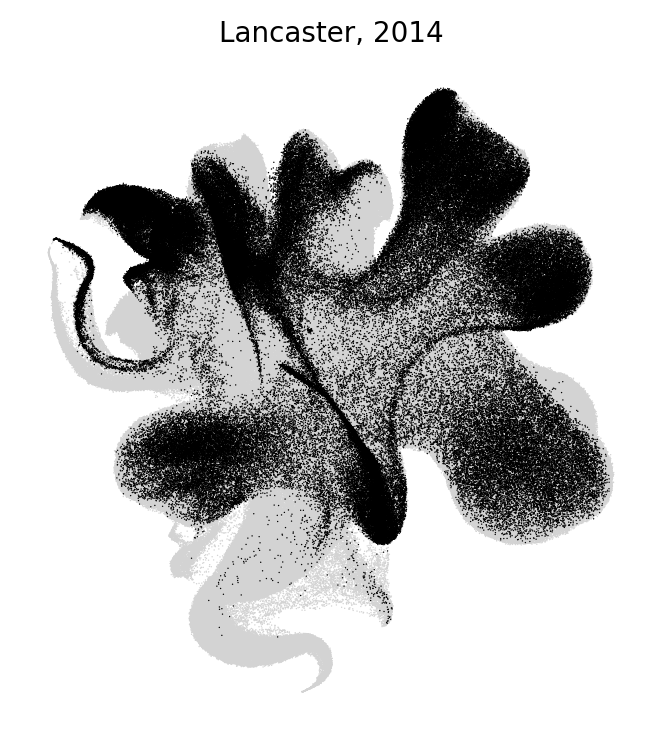

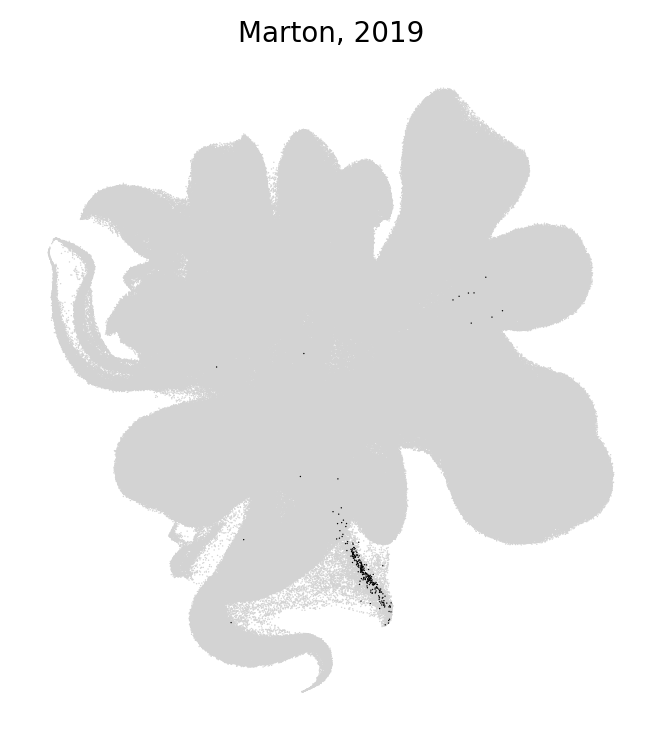

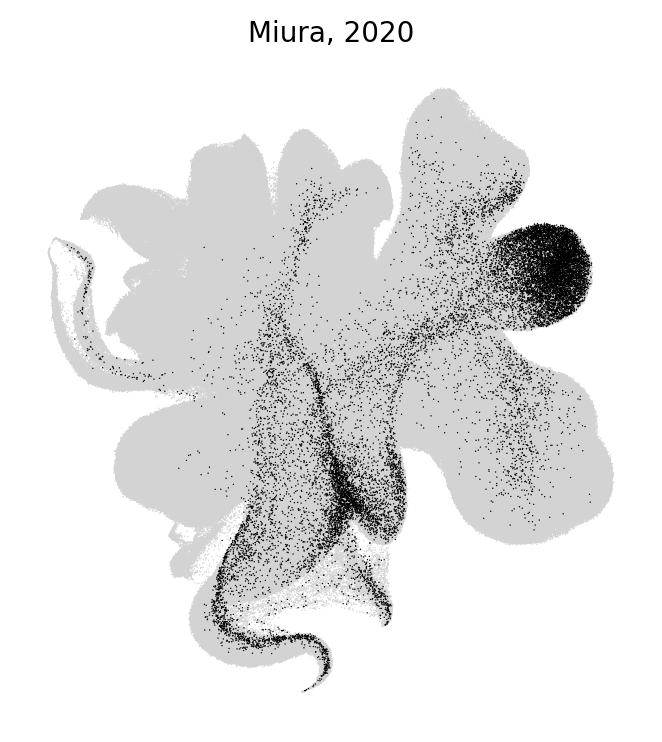

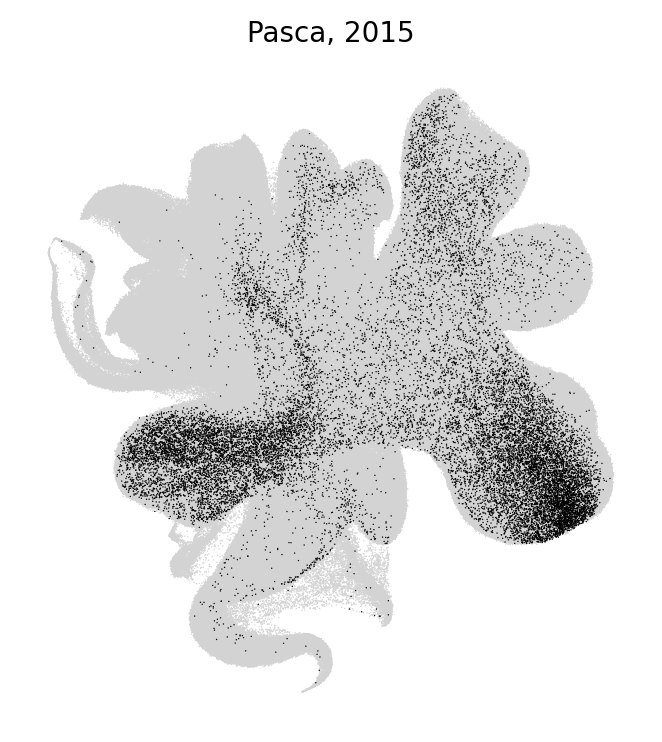

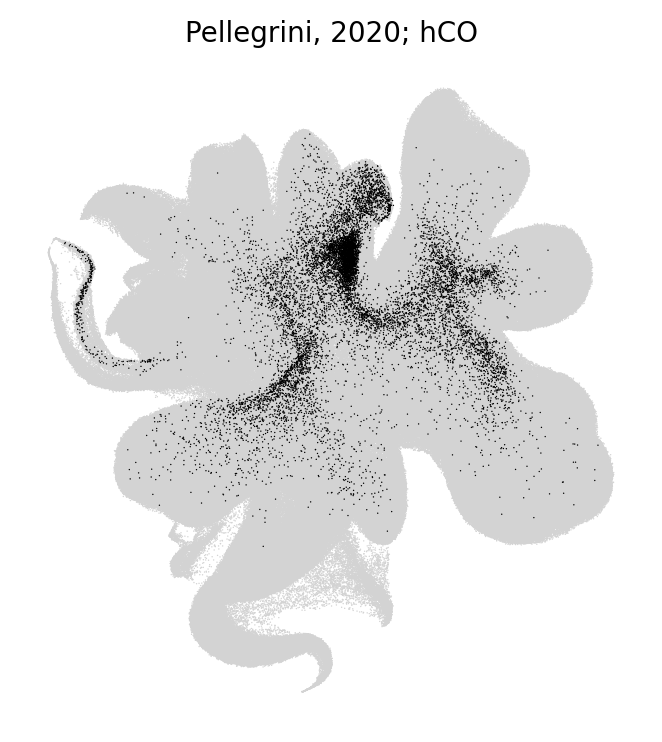

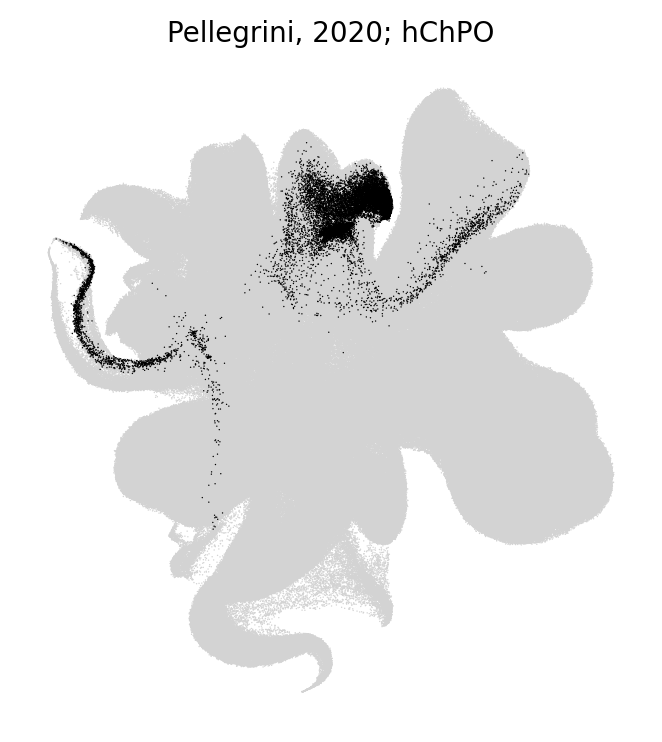

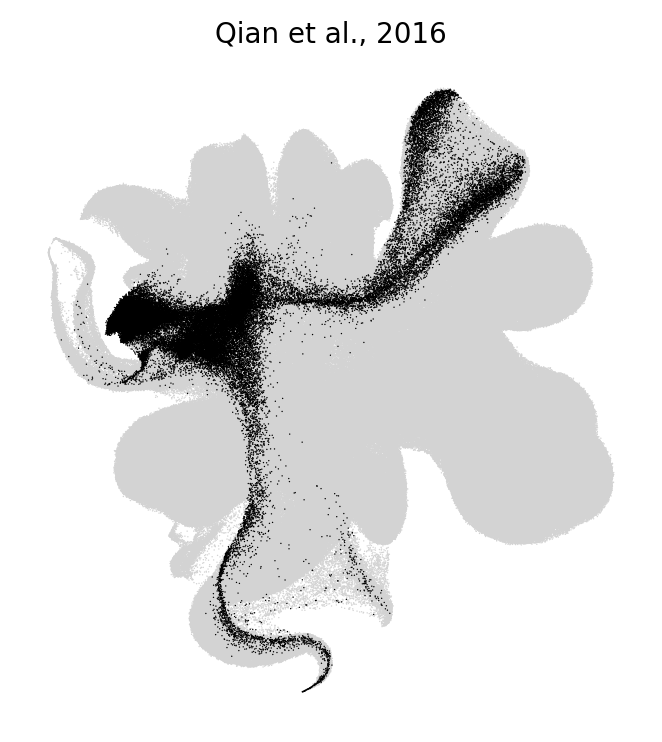

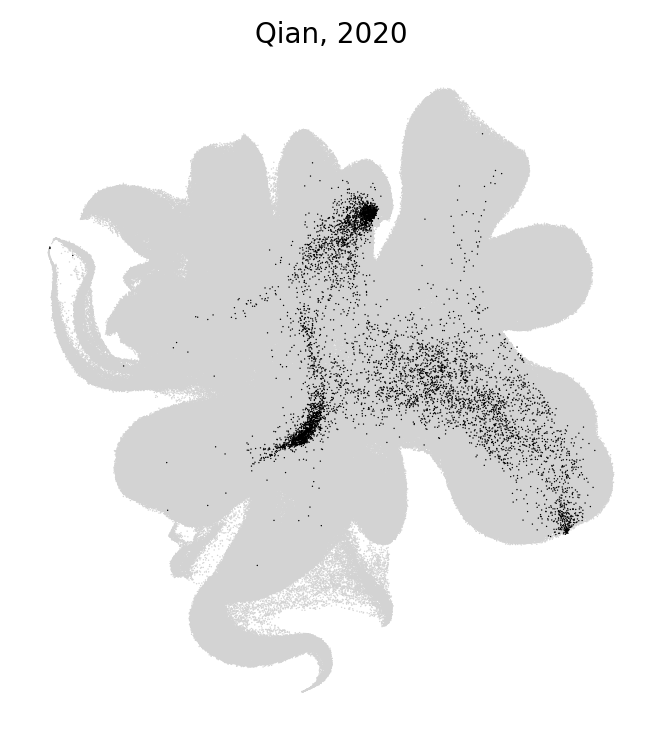

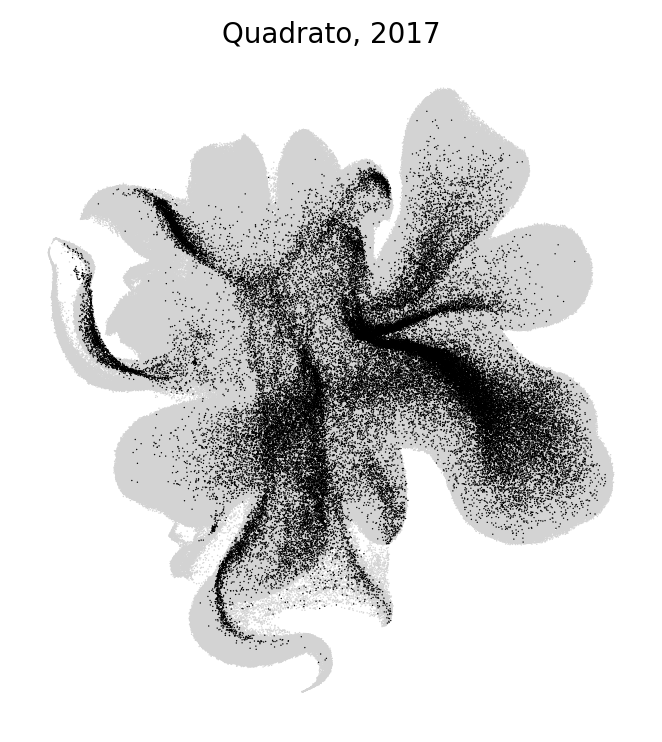

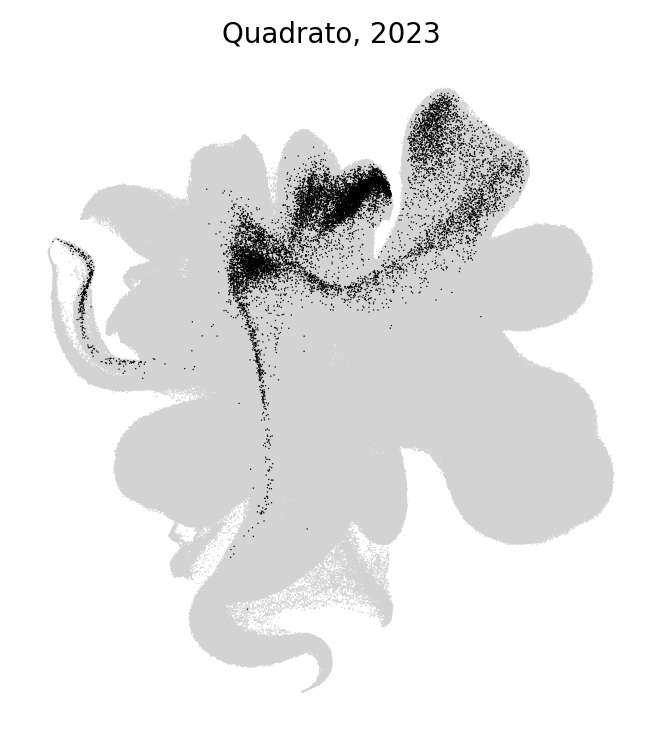

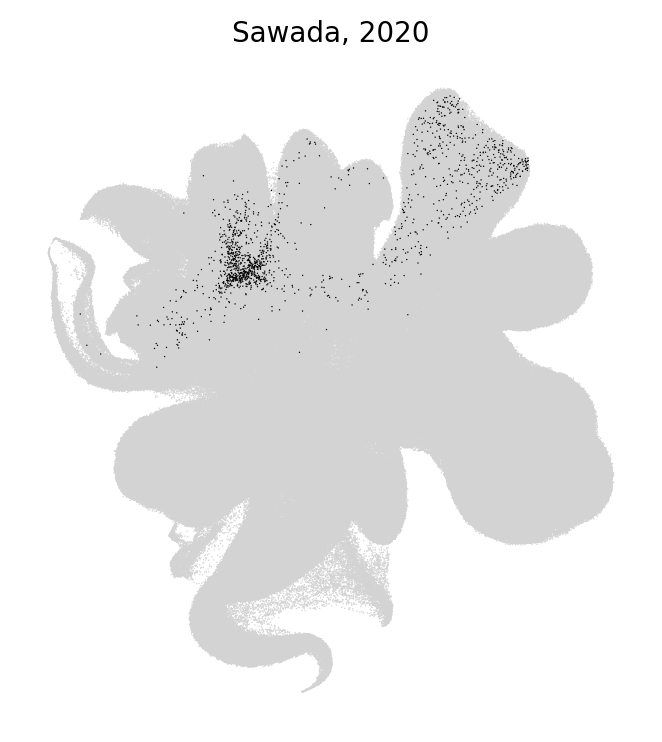

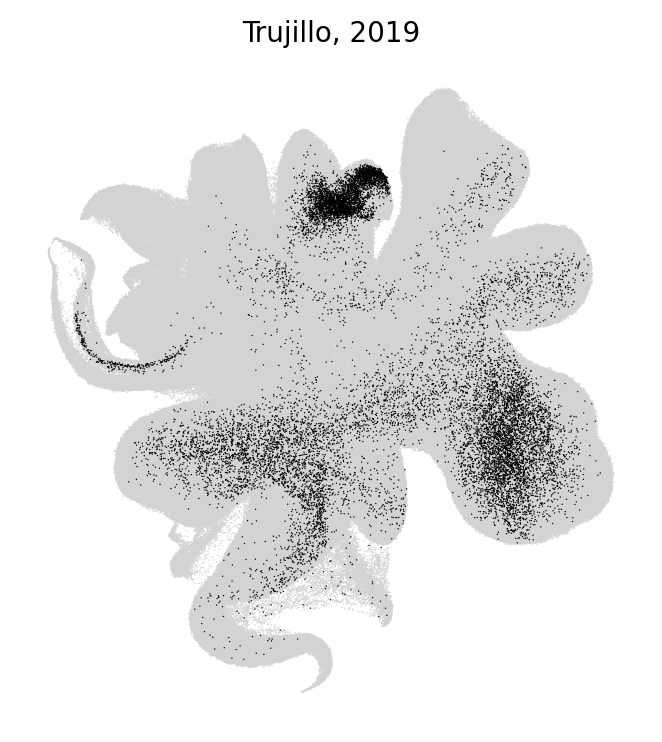

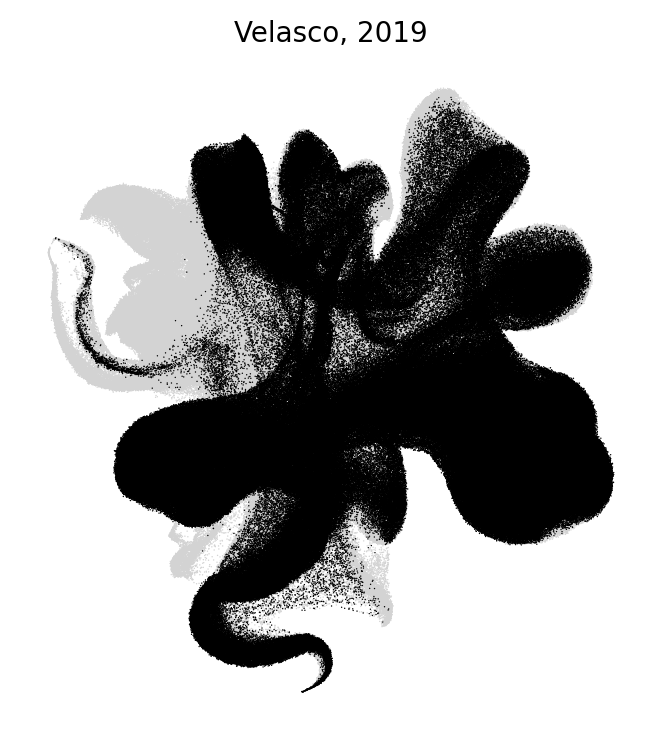

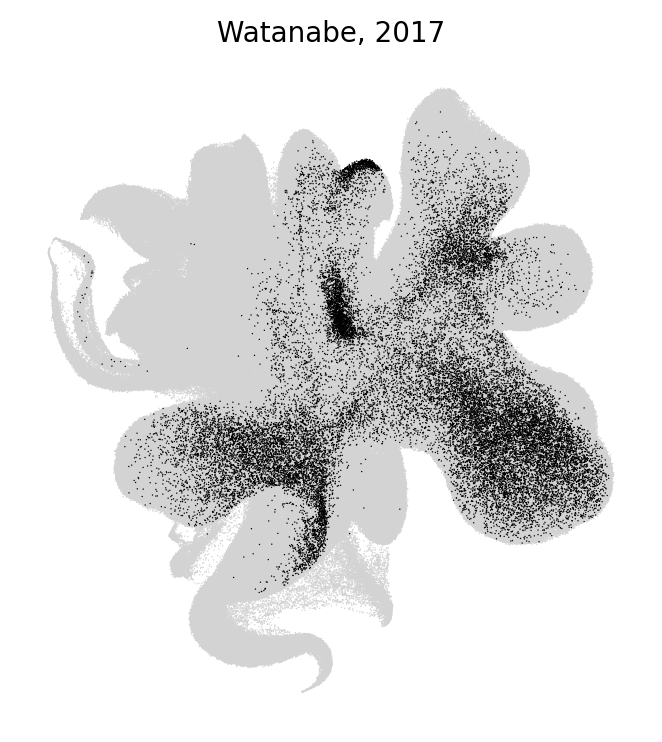

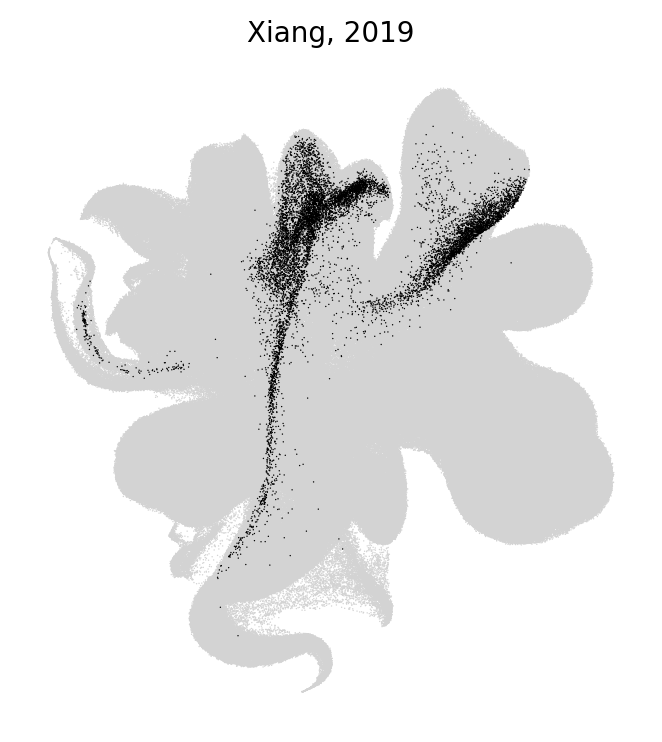

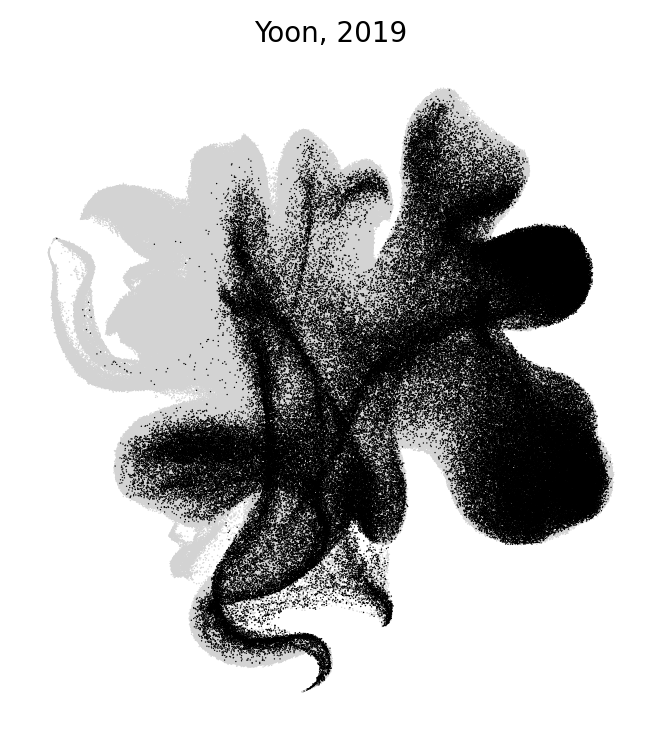

In [94]:
for k in adata.obs["assay_differentiation_clean"].cat.categories:
    sc.pl.scatter(adata, basis="umap_scpoli", color="assay_differentiation_clean", groups=[k], legend_loc="none", title=k, size=1, palette=["black"], save=f"_protocol_{k}.png")